In [1]:
import torch

q = torch.distributions.Normal(1, 2)
#sample with reparameterization trick
z = q.rsample()
#print(z)

p = torch.distributions.Normal(0, 1)
#q = torch.distributions.Normal(2, 4)

print(f"z size: {z.size()}")

log_pz = p.log_prob(z)
log_qzx = q.log_prob(z)

print(f"log pz size: {log_pz.size()}")

#print('log prob pz: ', log_pz, 'prob:', torch.exp(log_pz))
#print('log prob qzx: ', log_qzx, 'prob:', torch.exp(log_qzx))

kl_divergence = torch.mean(log_pz - log_qzx, 0)
print(kl_divergence)

z size: torch.Size([])
log pz size: torch.Size([])
tensor(0.3500)


We make use of Variational Inference to approximate the "true" posterior of the latent space $p(z|x)$ with an auxiliary distribution $q(z|x)$ by minimizing the KL Divergence between these two distribution:
$$ D_{KL}(q(z|x)||p(z|x)) = \sum q(z|x) \log \frac{q(z|x)}{p(z|x)} $$

We use a neural network to parameterize $q(z|x)$ such that we can minimize the $D_{KL}$ by training the network. $q(z|x)$ becomes our encoder that outputs the parameter $\theta$ of our distribution $q(z|x) = q_{\theta}(z|x)$. 

Recap the posterior is defined as (Bayes´ Rule):

$$
p(z|x) = \frac{Likelihood * Prior}{Marginal Distribution}=\frac{p(x|z)p(z)}{p(x)}
$$

We can derive the ELBO Loss from $D_{KL}(q(z|x)||p(z|x))$ which will be our overall loss function for our VAE:
\begin{align}
D_{KL}(q(z|x)||p(z|x)) &= \sum q(z|x) \log \frac{q(z|x)}{p(z|x)}\\
&= -\sum q(z|x) \log \frac{p(z|x)}{q(z|x)}\\
&= -\sum q(z|x)  \left[\log p(z|x) - \log q(z|x) \right]\\
&= -\sum q(z|x) \left[\log \frac{p(x|z)p(z)}{p(x)} - \log q(z|x) \right]\\
&= -\sum q(z|x) \left[\log p(x|z) + \log p(z) - \log p(x) - \log q(z|x) \right]\\
&= \sum q(z|x) \left[-\log p(x|z) - \log p(z) + \log p(x) + \log q(z|x) \right]\\
D_{KL}(q(z|x)||p(z|x)) - \sum q(z|x) \left[-\log p(x|z) - \log p(z) + \log q(z|x) \right] &= \log p(x)\\
-\sum q(z|x) \left[-\log p(x|z) + \log \frac{q(z|x)}{p(z)} \right] &= \\
-\mathbb{E}_{z \sim q(z|x)} \left[-\log p(x|z) + \log \frac{q(z|x)}{p(z)} \right] &=\\
-\mathbb{E}_{q} \left[-\log p(x|z) + \log \frac{q(z|x)}{p(z)} \right] &=\\
\mathbb{E}_{q} \left[\log p(x|z) - \log \frac{q(z|x)}{p(z)} \right] &=\\
D_{KL}(q(z|x)||p(z|x)) + \left[ \mathbb{E}_{q} \log p(x|z)  - \mathbb{E}_{q}  \log \frac{q(z|x)}{p(z)} \right] &= \log p(x)\\
D_{KL}(q(z|x)||p(z|x)) + Variational Lower Bound (ELBO) &= \log p(x) \\
ELBO &= \log p(x) - D_{KL}(q(z|x)||p(z|x)) \\
\left[ \mathbb{E}_{q} \log p(x|z)  - \mathbb{E}_{q}  \log \frac{q(z|x)}{p(z)} \right] &= \log p(x) - D_{KL}(q(z|x)||p(z|x)) \\
\left[ \mathbb{E}_{q} \log p(x|z)  - \mathbb{E}_{q}[ \log q(z|x) - \log p(z)] \right] &= \log p(x) - D_{KL}(q(z|x)||p(z|x)) \\
\left[ \mathbb{E}_{q} \log p(x|z)  - D_{KL}(q(x|z)||p(z)) \right] &= \log p(x) - D_{KL}(q(z|x)||p(z|x))   \leq \log p(x) \\
\end{align}

So if we maximize ELBO this corresponding to maximizing the log probability of generating real data samples $\log p(x)$ (lower bound) which is reduced by the divergence of our "true" and approximate distribution. Maximizing ELBO is same as minizing the negative ELBO:
$$ max(ELBO) = max \left( \mathbb{E}_{q} \log p(x|z)  - D_{KL}(q(x|z)||p(z)) \right) 
             = min \left((D_{KL}(q(x|z)||p(z)) - \mathbb{E}_{q} \log p(x|z) \right) = min(-ELBO) $$

In [1]:
def kl_divergence(z, mu, std):
    """
    Monte Carlo KL Divergence 
    """
    # Standard Gaussian as target distribution p(z)
    p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
    # Auxiliary distribution q(x|z)
    q = torch.distributions.Normal(mu, std)
    
    
    # KL Divergence according to our ELBO derivation
    kl = (q.log_prob(z) - p.log_prob(z))
    
    # trick to sum over last dimension as sampling from multivariant gaussian 
    return kl.sum(-1)



Reconstruction Loss ...

In [2]:
def reconstruction_loss(x_hat, logscale, x):
    """
    Reconstruction Loss as Regularization
    """
    scale = torch.exp(logscale)
    mean = x_hat
    dist = torch.distributions.Normal(mean, scale)
    
    return dist.log_prob(x).sum(dim=(1,2,3))

Variational Autoencoder

In [3]:
import pytorch_lightning as pl
import torch
from torch import nn
from torch.nn import functional as F
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)


class VAE(pl.LightningModule):
    """
    VAE model
    """
    
    def __init__(self, enc_out_dim = 512, latent_dim = 256, input_height = 32):
        
        super().__init__()
        
        
        self.save_hyperparameters()

        # encoder q(z|x) => output: distribution param
        self.encoder = resnet18_encoder(False, False)
        
        #decoder p(x|z) => output: sample from high-dim. distribution of input image shape
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim, 
            input_height=input_height, 
            first_conv=False, 
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)
        
        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))
        
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)
    
    
    def training_step(self, batch, batch_idx):
        x, _ = batch

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded 
        x_hat = vae.decoder(z)

        # reconstruction loss
        recon_loss = reconstruction_loss(x_hat, self.log_scale, x)

        # kl
        kl = kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(), 
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo

d:\Users\qrno9\miniconda3\envs\pokemon\lib\site-packages\pl_bolts\callbacks\data_monitor.py:28: UnderReviewWarning: The feature warn_missing_pkg is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  warn_missing_pkg("wandb")
d:\Users\qrno9\miniconda3\envs\pokemon\lib\site-packages\pl_bolts\models\self_supervised\amdim\amdim_module.py:35: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
d:\Users\qrno9\miniconda3\envs\pok

In [4]:
from pl_bolts.datamodules import CIFAR10DataModule

datamodule = CIFAR10DataModule('.')

In [5]:
import warnings


pl.seed_everything(1234)
torch.set_float32_matmul_precision('high')

vae = VAE()
trainer = pl.Trainer(devices=1, accelerator="gpu", max_epochs=30)

#with warnings.catch_warnings('ignore')
trainer.fit(vae, datamodule)

Global seed set to 1234
C:\Users\qrno9\AppData\Local\Temp\ipykernel_23672\1260390691.py:24: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.encoder = resnet18_encoder(False, False)
d:\Users\qrno9\miniconda3\envs\pokemon\lib\site-packages\pl_bolts\models\autoencoders\components.py:334: UnderReviewWarning: The feature ResNetEncoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  return ResNetEncoder(EncoderBlock, [2, 2, 2, 2], first_conv, maxpool1)
d:\Users\qrno9\minico

Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params
------------------------------------------
0 | encoder | ResNetEncoder | 11.2 M
1 | decoder | ResNetDecoder | 8.6 M 
2 | fc_mu   | Linear        | 131 K 
3 | fc_var  | Linear        | 131 K 
------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params
80.228    Total estimated model params size (MB)
d:\Users\qrno9\miniconda3\envs\pokemon\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


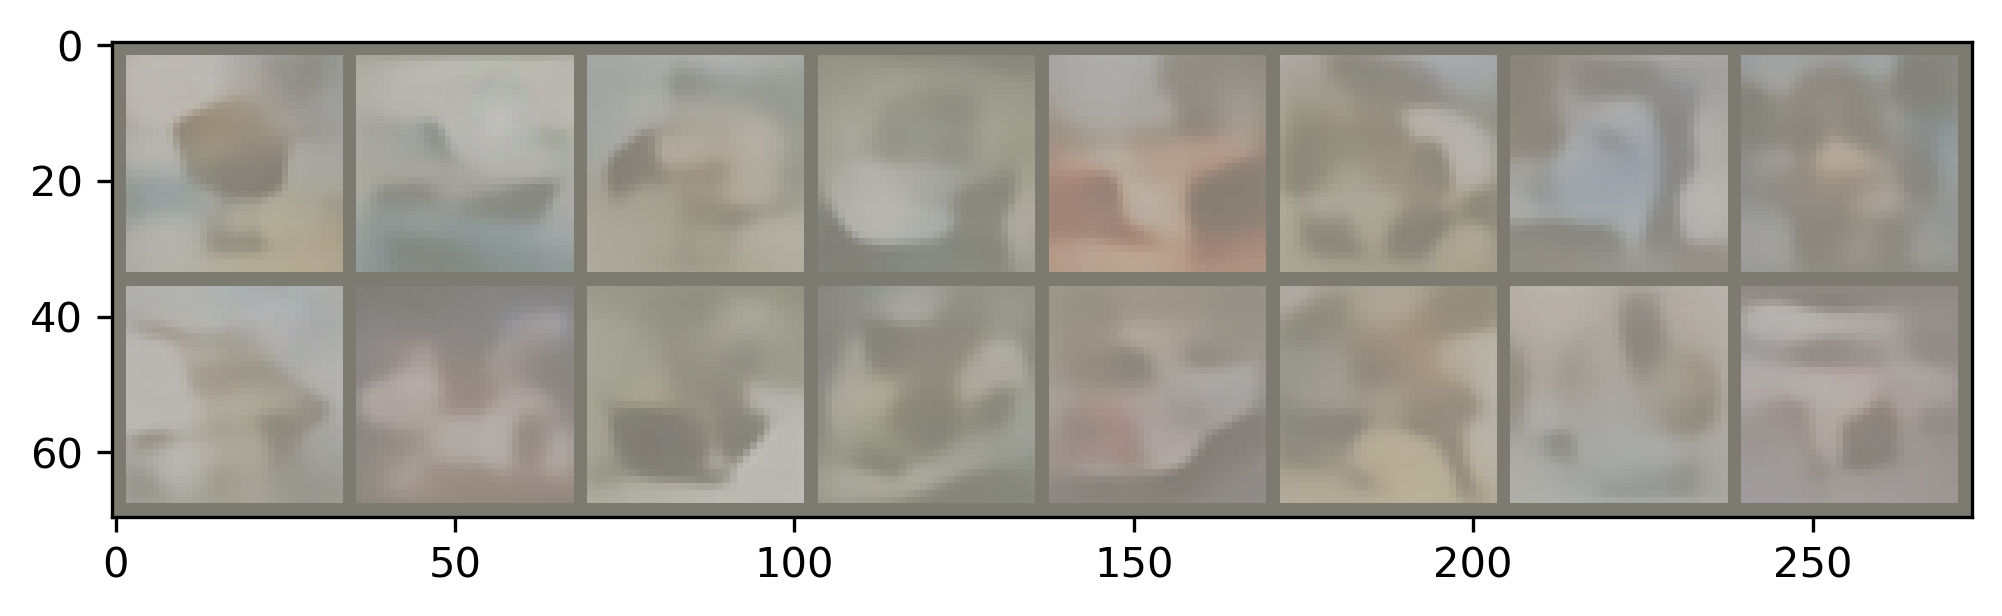

In [6]:
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
figure(figsize=(8, 3), dpi=300)

# Z COMES FROM NORMAL(0, 1)
num_preds = 16
pl_module = vae
rand_v = torch.rand((num_preds, pl_module.hparams.latent_dim), device=pl_module.device)
p = torch.distributions.Normal(torch.zeros_like(rand_v), torch.ones_like(rand_v))
z = p.rsample()

# SAMPLE IMAGES
with torch.no_grad():
    pred = vae.decoder(z.to(vae.device)).cpu()

# UNDO DATA NORMALIZATION
normalize = cifar10_normalization()
mean, std = np.array(normalize.mean), np.array(normalize.std)
img = make_grid(pred).permute(1, 2, 0).numpy() * std + mean

# PLOT IMAGES
imshow(img)